In [1]:
import numpy as np
import math
import scipy.stats as scps
import matplotlib.pyplot as plt

Quadrature points

In [2]:
def quadrature(n, lbnd, ubnd):
    
    x1 = lbnd
    x2 = ubnd
    x = np.zeros(n)
    w = x
    EPS = 3e-14
    m = int(round((n+EPS)/2)) # flor function in matlab, rounding to the lower integer
    xm = (x2+x1)/2
    xl = (x2-x1)/2
    z1 = 1e99

    x = np.full(n+1, np.nan)
    w = np.full(n+1, np.nan)

    i = 1

    while i <= m:

        z = math.cos(math.pi*(i - 0.25)/(n + 0.5))

        while abs(z - z1) > EPS:
            p1 = 1
            p2 = 0
            j = 1

            while j <= n:
                p3 = p2
                p2 = p1
                p1 = ((2*j -1)*z*p2 - (j-1)*p3)/j
                j += 1

            pp = n*(z*p1 - p2)/(z*z - 1)
            z1 = z
            z = z1 - p1/pp

        x[i] = xm - xl*z
        x[n + 1 - i] = xm + xl*z
        w[i] = 2*xl/((1-z*z)*pp*pp)
        w[n + 1 - i] = w[i]
        i += 1

    x = x[1:]
    w = w[1:]

    return x, w

Minimal
=======

In [ ]:
EXPN = 10 # number of quadrature points
MMAX = 10 # maximum savings
NM = 100 # number of EGM gridpoints
TBAR = 25 # number of periods
SIGMA = 0.25 # sigma of normal distribution
Y = 1 # period income
R = 0.05 # interest rate
DF = 0.95 # discount factor

step = MMAX/NM

In [ ]:
# create quadrature nodes and weights
quadp, quadw = quadrature(EXPN, 0, 1)

# process through inverse normal distribution
quadstnorm = scps.norm.ppf(quadp)

# fix exogenous grod points on savings
savingsgrid = np.linspace(0, MMAX, NM)

In [ ]:
policy = np.full((NM + 1, 2, TBAR - 1), np.nan)
policy[0, :, :] = 0.00

In [ ]:
# Backward induction

for period in reversed(range(TBAR - 1)): # starts at 23, end at zero

    # obtain next periods wealth at every exog. savings point (A_{t+1}) using budget constraint
    w1 = Y + np.multiply((np.exp(quadstnorm*SIGMA)*(1+R)).reshape(10,1), savingsgrid) # M_{t+1}, dim (EXPN, NM)

    # every wealth level in t+1 corresponds to an optimal consumption level
    # since wealth points might be off grid, get optimal consumption using extrapolation
    if period == TBAR - 2:
        c1 = w1 # separate handling of last period
    else:
        # interpolate
        c1 = np.interp(w1, policy[:, 0, period + 1], policy[:, 1, period+1]) # c_{t+1}
        # extrapolate
        slope = (policy[-2, 1, period + 1] - policy[-1, 1, period + 1])/(policy[-2, 0, period + 1] - policy[-1, 0, period + 1])
        intercept = policy[-1, 1, period + 1] - policy[-1, 0, period + 1]*slope
        c1[c1 == np.max(policy[:, 1, period+1])] = intercept + slope*w1[c1 == np.max(policy[:, 1, period+1])]

    # obtain current period optimal consumption and wealth via Euler equation
    # since Euler eq. involves c_{t+1} above computations were necessary
    rhs = np.dot(quadw.T, 1/c1)
    policy[1:, 1, period] = 1/(DF*(1+R)*rhs)
    policy[1:, 0, period] = savingsgrid + policy[1:, 1, period]

Retirement
==========

Common elements
----------------------

In [3]:
# Model parameters (default)

Tbar = 25 # number of periods (fist period is t=1) 
ngridm = 500 # number of grid points over assets
mmax = 50 # maximum level of assets
expn = 5 # number of quadrature points used in calculation of expectations
nsims = 10 # number of simulations
init = [10, 30] # interval of the initial wealth
r = 0.05 # interest rate
df = 0.95 # discount factor
sigma = 0.25 # sigma parameter in income shocks
duw = 0.35 #disutility of work
theta = 1.95 # CRRA coefficient (log utility if ==1)
inc0 = 0.75 # income equation: constant
inc1 = 0.04 # income equation: age coef
inc2 = 0.0002 # income equation: age^2 coef
cfloor =0.001 # consumption floor (safety net in retirement)
lambda_ = 0.02 # scale of the EV taste shocks 

In [4]:
# Functions: utility and budget constraint

def util(consumption, working):
    """CRRA utility"""
    
    u = (consumption**(1-theta)-1)/(1-theta)
    u = u - duw*(working)
    
    return u

def mutil(consumption):
    """Marginal utility CRRA"""
    
    mu = consumption**(-theta)
    
    return mu

def imutil(mutil):
    """Inverse marginal utility CRRA
    Consumption as a function of marginal utility"""
    
    cons = mutil**(-1/theta)
    
    return cons


def income(it, shock):
    """Income in period it given normal shock"""
    
    age = it + 20 # matlab strats counting at 1, Python at zero
    w = np.exp(inc0 + inc1*age - inc2*age**2 + shock)
    
    return w


def budget(it, savings, shocks, working):
    """Wealth, M_{t+1} in period t+1, where it == t
    
    Arguments
    ---------
        savings: np.array of savings with length ngridm
        shocks: np.array of shocks with length expn
    
    Returns
    -------
        w1: matrix with dimension (expn, ngridm) of all possible
    next period wealths
    """
    
    w1 = np.full((ngridm, expn), income(it + 1, shocks)*working).T + np.full((expn, ngridm), savings*(1+r))
    
    return w1

def mbudget():
    """Marginal budget:
    Derivative of budget with respect to savings"""
    
    mw1 = np.full((expn, ngridm), (1+r))
    
    return mw1

In [5]:
# Value function for worker

def value_function(working, it, x):
    """Value function calculation for the """
    
    x = x.flatten('F')
    
    res = np.full(x.shape, np.nan)
    
    # Mark constrained region
    mask = x < value[1, 0, working, it] # credit constraint between 1st (M_{t+1) = 0) and second point (A_{t+1} = 0)
    
    # Calculate t+1 value function in the constrained region
    res[mask] = util(x[mask], working) + df*value[0, 1, working, it]
    
    # Calculate t+1 value function in non-constrained region
    # interpolate
    res[~mask] = np.interp(x[~mask], value[:, 0, working, it], value[:, 1, working, it])
    # extrapolate
    slope = (value[-2, 1, working, it] - value[-1, 1, working, it])/(value[-2, 0, working, it] - value[-1, 0, working, it])
    intercept = value[-1, 1, working, it] - value[-1, 0, working, it]*slope
    res[res == np.max(value[:, 1, working, it])] = intercept + slope*x[res == np.max(value[:, 1, working, it])]

    return res

In [6]:
# Calculation of probability to choose work, if a worker today
def chpr(x):
    """Calculate the probability of choosing work in t+1
    for state worker given t+1 value functions"""
    
    mx = np.amax(x, axis = 0)
    mxx = x - mx
    res = np.exp(mxx[1, :]/lambda_)/np.sum(np.exp(mxx/lambda_), axis = 0)
    
    return res

In [7]:
# Expected value function calculation in state worker
def logsum(x):
    """Calculate expected value function"""
    
    mx = np.amax(x, axis = 0)
    mxx = x - mx
    res = mx + lambda_*np.log(np.sum(np.exp(mxx/lambda_), axis = 0))
    
    return res

Solve EGM
-------------

This is the solution to the workers problem.

Code for last and second to last period. Produces same values as matlab code for the same periods.

Questions:
* Value for worker who choses to retire, period second to last, is NOT the same as value for retiree in second to last period. Also in Matlab code. Why?

In [8]:
# Initialize grids
quadp, quadw = quadrature(expn,0,1)
quadstnorm = scps.norm.ppf(quadp)
savingsgrid = np.linspace(0, mmax, ngridm)

In [9]:
# Initialize containers

# Container for endogenous gridpoints of (beginning-of-period) assets
# and corresponding consumption
policy = np.full((ngridm + 1, 2, 2, Tbar), np.nan)

# Value functions
value = np.full((ngridm + 1, 2, 2, Tbar), np.nan)

In [10]:
# Handling of last period and first elements
# policy
policy[1:, 0, 0, Tbar-1] = savingsgrid
policy[1:, 0, 1, Tbar-1] = savingsgrid
policy[1:, 1, :, Tbar-1] = policy[1:, 0, :, Tbar-1]
policy[0, :, :, :] = 0.00

In [11]:
# value
value[2:, 0, :, Tbar-1] = util(policy[2:, 0, :, Tbar-1], 0)
value[2:, 1, :, Tbar-1] = util(policy[2:, 0, :, Tbar-1], 1)
value[0:2, :, :, Tbar -1] = 0.00
value[0, 0, :, :] = 0.00

Solution default parametrisation EGM only
--------------------------------------------------

Note: Default parametrisation refers to the parameter values specified in the begining of the MatLab class in model_retirement.m, here found in the cell "Model parameters (default)". 

In [12]:
for period in reversed(range(Tbar - 1)): # starts at 23, end at zero
    
    for choice in[0, 1]:

        # M_{t+1}
        wk1 = budget(period, savingsgrid, quadstnorm*sigma, choice)
        wk1[wk1 < cfloor] = cfloor

        # Value function
        vl1 = np.full((2, ngridm * expn), np.nan)

        if period + 1 == Tbar - 1:
            vl1[0, :] = util(wk1, 0).flatten('F')
            vl1[1, :] = util(wk1, 1).flatten('F')
        else:
            vl1[1, :] = value_function(1, period + 1, wk1) # value function in t+1 if choice in t+1 is work
            vl1[0, :] = value_function(0, period + 1, wk1) # value function in t+1 if choice in t+1 is retiree

        # Probability of choosing work in t+1
        if choice == 0:
            # Probability of choosing work in t+1
            pr1 = np.full(2500, 0.00)
        else:
            pr1 = chpr(vl1)

        # Next period consumption based on interpolation and extrapolation
        # given grid points and associated consumption
        cons10 = np.interp(wk1, policy[:, 0, 0, period + 1], policy[:, 1, 0, period+1])
        # extrapolate linearly right of max grid point
        slope = (policy[-2, 1, 0, period + 1] - policy[-1, 1, 0, period + 1])/(policy[-2, 0, 0, period + 1] - policy[-1, 0, 0, period + 1])
        intercept = policy[-1, 1, 0, period + 1] - policy[-1, 0, 0, period + 1]*slope
        cons10[cons10 == np.max(policy[:, 1, 0, period+1])] = intercept + slope*wk1[cons10 == np.max(policy[:, 1, 0, period+1])]
        cons10_flat = cons10.flatten('F')

        cons11 = np.interp(wk1, policy[:, 0, 1, period + 1], policy[:, 1, 1, period+1])
        # extrapolate linearly right of max grid point
        slope = (policy[-2, 1, 1, period + 1] - policy[-1, 1, 1, period + 1])/(policy[-2, 0, 1, period + 1] - policy[-1, 0, 1, period + 1])
        intercept = policy[-1, 1, 1, period + 1] - policy[-1, 0, 1, period + 1]*slope
        cons11[cons11 == np.max(policy[:, 1, 1, period+1])] = intercept + slope*wk1[cons11 == np.max(policy[:, 1, 1, period+1])]
        cons11_flat = cons11.flatten('F')

        # Marginal utility of expected consumption next period
        mu1 = pr1*mutil(cons11_flat) + (1 - pr1)*mutil(cons10_flat)

        # Marginal budget
        # Note: Constant for this model formulation (1+r)
        mwk1 = mbudget()

        # RHS of Euler eq., p 337, integrate out error of y
        rhs = np.dot(quadw.T, np.multiply(mu1.reshape(wk1.shape, order = 'F'), mwk1))

        # Current period consumption from Euler equation
        cons0 = imutil(df*rhs)

        # Update containers related to consumption
        policy[1:, 1, choice, period] = cons0
        policy[1:, 0, choice, period] = savingsgrid + cons0


        if choice == 1:
            # Calculate continuation value
            ev = np.dot(quadw.T, logsum(vl1).reshape(wk1.shape, order = 'F'))
        else:
            ev = np.dot(quadw.T, vl1[0, :].reshape(wk1.shape, order = 'F'))

        # Update value function related containers
        value[1:, 1, choice, period] = util(cons0, choice) + df*ev
        value[1:, 0, choice, period] = savingsgrid + cons0
        value[0, 1, choice, period] = ev[0]

Minimal schocks illustration of EGM failure
--------------------------------------------------

In [13]:
# Initialize grids
quadp, quadw = quadrature(expn,0,1)
quadstnorm = scps.norm.ppf(quadp)
savingsgrid = np.linspace(0, mmax, ngridm)

In [14]:
# Initialize containers

# Container for endogenous gridpoints of (beginning-of-period) assets
# and corresponding consumption
policy = np.full((ngridm + 1, 2, 2, Tbar), np.nan)

# Value functions
value = np.full((ngridm + 1, 2, 2, Tbar), np.nan)

In [15]:
# Handling of last period and first elements
# policy
policy[1:, 0, 0, Tbar-1] = savingsgrid
policy[1:, 0, 1, Tbar-1] = savingsgrid
policy[1:, 1, :, Tbar-1] = policy[1:, 0, :, Tbar-1]
policy[0, :, :, :] = 0.00

In [16]:
# value
value[2:, 0, :, Tbar-1] = util(policy[2:, 0, :, Tbar-1], 0)
value[2:, 1, :, Tbar-1] = util(policy[2:, 0, :, Tbar-1], 1)
value[0:2, :, :, Tbar -1] = 0.00
value[0, 0, :, :] = 0.00

In [17]:
# Minimal shocks
sigma = 0
lambda_ = 2.2204e-16

In [18]:
# Solve for period T-1 and T-2
for period in [23, 22]:
    
    for choice in[0, 1]:

        # M_{t+1}
        wk1 = budget(period, savingsgrid, quadstnorm*sigma, choice)
        wk1[wk1 < cfloor] = cfloor

        # Value function
        vl1 = np.full((2, ngridm * expn), np.nan)

        if period + 1 == Tbar - 1:
            vl1[0, :] = util(wk1, 0).flatten('F')
            vl1[1, :] = util(wk1, 1).flatten('F')
        else:
            vl1[1, :] = value_function(1, period + 1, wk1) # value function in t+1 if choice in t+1 is work
            vl1[0, :] = value_function(0, period + 1, wk1) # value function in t+1 if choice in t+1 is retiree

        # Probability of choosing work in t+1
        if choice == 0:
            # Probability of choosing work in t+1
            pr1 = np.full(2500, 0.00)
        else:
            pr1 = chpr(vl1)

        # Next period consumption based on interpolation and extrapolation
        # given grid points and associated consumption
        cons10 = np.interp(wk1, policy[:, 0, 0, period + 1], policy[:, 1, 0, period+1])
        # extrapolate linearly right of max grid point
        slope = (policy[-2, 1, 0, period + 1] - policy[-1, 1, 0, period + 1])/(policy[-2, 0, 0, period + 1] - policy[-1, 0, 0, period + 1])
        intercept = policy[-1, 1, 0, period + 1] - policy[-1, 0, 0, period + 1]*slope
        cons10[cons10 == np.max(policy[:, 1, 0, period+1])] = intercept + slope*wk1[cons10 == np.max(policy[:, 1, 0, period+1])]
        cons10_flat = cons10.flatten('F')

        cons11 = np.interp(wk1, policy[:, 0, 1, period + 1], policy[:, 1, 1, period+1])
        # extrapolate linearly right of max grid point
        slope = (policy[-2, 1, 1, period + 1] - policy[-1, 1, 1, period + 1])/(policy[-2, 0, 1, period + 1] - policy[-1, 0, 1, period + 1])
        intercept = policy[-1, 1, 1, period + 1] - policy[-1, 0, 1, period + 1]*slope
        cons11[cons11 == np.max(policy[:, 1, 1, period+1])] = intercept + slope*wk1[cons11 == np.max(policy[:, 1, 1, period+1])]
        cons11_flat = cons11.flatten('F')

        # Marginal utility of expected consumption next period
        mu1 = pr1*mutil(cons11_flat) + (1 - pr1)*mutil(cons10_flat)

        # Marginal budget
        # Note: Constant for this model formulation (1+r)
        mwk1 = mbudget()

        # RHS of Euler eq., p 337, integrate out error of y
        rhs = np.dot(quadw.T, np.multiply(mu1.reshape(wk1.shape, order = 'F'), mwk1))

        # Current period consumption from Euler equation
        cons0 = imutil(df*rhs)

        # Update containers related to consumption
        policy[1:, 1, choice, period] = cons0
        policy[1:, 0, choice, period] = savingsgrid + cons0


        if choice == 1:
            # Calculate continuation value
            ev = np.dot(quadw.T, logsum(vl1).reshape(wk1.shape, order = 'F'))
        else:
            ev = np.dot(quadw.T, vl1[0, :].reshape(wk1.shape, order = 'F'))

        # Update value function related containers
        value[1:, 1, choice, period] = util(cons0, choice) + df*ev
        value[1:, 0, choice, period] = savingsgrid + cons0
        value[0, 1, choice, period] = ev[0]

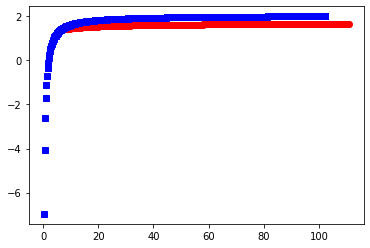

In [64]:
# EGM produces a suboptimal solution also in period T-1
# However, correction is necessary in the credit constraint region.
# Since this is a special case, we focus on another period for illustrative purposes, namely, T-3
plt.plot(value[3:500, 0, 1, 23], value[3:500, 1, 1, 23], 'ro', value[3:500, 0, 0, 23], value[3:500, 1, 0, 23], 'bs')

In [19]:
# Start solution for T-3 line by line
period = 21
choice = 1

In [20]:
# M_{t+1}
wk1 = budget(period, savingsgrid, quadstnorm*sigma, choice)
wk1[wk1 < cfloor] = cfloor

[0, 60, 0, 80]

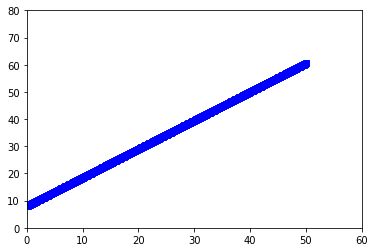

In [23]:
# Liniar assets M_{t+1}, same in every period
plt.plot(savingsgrid, wk1[1, :], 'bs')
plt.axis([0, 60, 0, 80])

In [24]:
# Value function
vl1 = np.full((2, ngridm * expn), np.nan)

if period + 1 == Tbar - 1:
    vl1[0, :] = util(wk1, 0).flatten('F')
    vl1[1, :] = util(wk1, 1).flatten('F')
else:
    vl1[1, :] = value_function(1, period + 1, wk1) # value function in t+1 if choice in t+1 is work
    vl1[0, :] = value_function(0, period + 1, wk1) # value function in t+1 if choice in t+1 is retiree

In [25]:
wk1_flat = wk1.flatten('F')

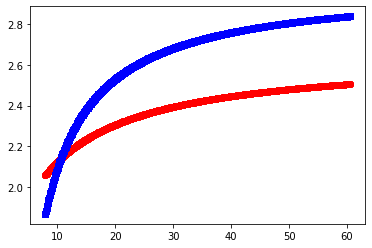

In [27]:
# Intersection of value functions for t+1 at M_{t+1} bar
# Choose work below (to the left) and retirement above (to the right).
plt.plot(wk1_flat, vl1[1, :], 'ro', wk1_flat, vl1[0, :], 'bs')

In [28]:
# Probability of choosing work in t+1
if choice == 0:
    # Probability of choosing work in t+1
    pr1 = np.full(2500, 0.00)
else:
    pr1 = chpr(vl1)

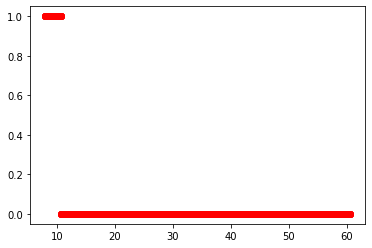

In [30]:
plt.plot(wk1_flat, pr1, 'ro')
# Probability swotch from 1 to zero at index 129, 130 of M_{t+1}
# M_{t+1} bar leis between these points

In [31]:
# Look at vl at these indexes
print(vl1[1, 129:131], vl1[0, 129:131])

[2.14023746 2.14300772] [2.13866126 2.14671571]


In [32]:
# Look at wk1 at this point
wk1_flat[129:131]

array([10.61234827, 10.71755869])

In [33]:
# Next period consumption based on interpolation and extrapolation
# given grid points and associated consumption
cons10 = np.interp(wk1, policy[:, 0, 0, period + 1], policy[:, 1, 0, period+1])
# extrapolate linearly right of max grid point
slope = (policy[-2, 1, 0, period + 1] - policy[-1, 1, 0, period + 1])/(policy[-2, 0, 0, period + 1] - policy[-1, 0, 0, period + 1])
intercept = policy[-1, 1, 0, period + 1] - policy[-1, 0, 0, period + 1]*slope
cons10[cons10 == np.max(policy[:, 1, 0, period+1])] = intercept + slope*wk1[cons10 == np.max(policy[:, 1, 0, period+1])]
cons10_flat = cons10.flatten('F')

cons11 = np.interp(wk1, policy[:, 0, 1, period + 1], policy[:, 1, 1, period+1])
# extrapolate linearly right of max grid point
slope = (policy[-2, 1, 1, period + 1] - policy[-1, 1, 1, period + 1])/(policy[-2, 0, 1, period + 1] - policy[-1, 0, 1, period + 1])
intercept = policy[-1, 1, 1, period + 1] - policy[-1, 0, 1, period + 1]*slope
cons11[cons11 == np.max(policy[:, 1, 1, period+1])] = intercept + slope*wk1[cons11 == np.max(policy[:, 1, 1, period+1])]
cons11_flat = cons11.flatten('F')

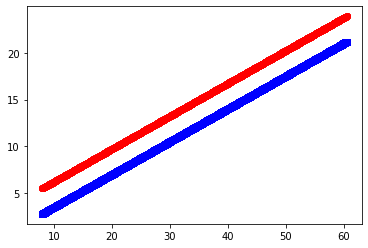

In [35]:
plt.plot(wk1_flat, cons11_flat, 'ro', wk1_flat, cons10_flat, 'bs')
# Consumption for choise work uniformly above consumption induced by choice retirement

In [36]:
# Marginal utility of expected consumption next period
mu1 = pr1*mutil(cons11_flat) + (1 - pr1)*mutil(cons10_flat)

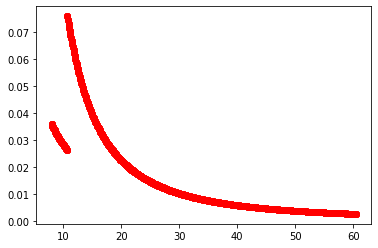

In [37]:
plt.plot(wk1_flat, mu1, 'ro')

In [38]:
# Discontinuity at same index points
mu1[129:131]

array([0.02646658, 0.07585792])

In [39]:
# Marginal budget
# Note: Constant for this model formulation (1+r)
mwk1 = mbudget()

# RHS of Euler eq., p 337, integrate out error of y
rhs = np.dot(quadw.T, np.multiply(mu1.reshape(wk1.shape, order = 'F'), mwk1))

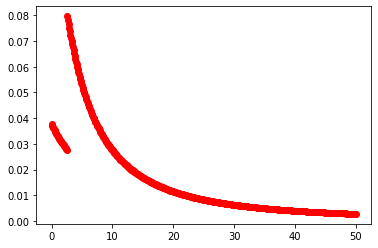

In [40]:
plt.plot(savingsgrid, rhs, 'ro')

In [41]:
# Discontinuity at wk1 values times (1+r)
rhs[25:27]

array([0.02778991, 0.07965082])

In [42]:
# Current period consumption from Euler equation
cons0 = imutil(df*rhs)

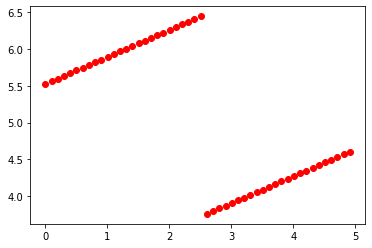

In [61]:
plt.plot(savingsgrid[0:50], cons0[0:50], 'ro')
# Parallel drop in consumption at the switching point from choice work to choice retire.

In [44]:
# Consumption drops at same index point
cons0[25:27]

array([6.44807942, 3.757647  ])

In [45]:
policy[1:, 1, choice, period] = cons0
policy[1:, 0, choice, period] = savingsgrid + cons0

In [46]:
new_x = savingsgrid + cons0

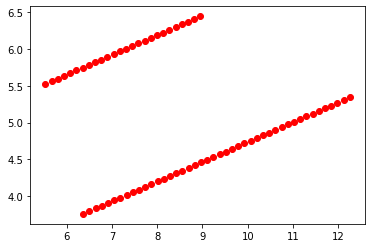

In [47]:
# Graph as in Figure 1, panel (b), paper p. 329
# Note: M_t is the sum of savings and current period consumption.
# Savingsgrid id monotonically (and also linearly) increasing on the range 0-500,
# Consumption is discontinuous at the switching point from choice work to retire - it drops!
# Since consumption drops, also M_t drops, and as M_t is on the x axis, the drop is equivalent to a lefward shift.
# This is how we, mechanically end up with a region of M_t, where there are two solutions for consumption,
# which contradicts theorem 2 in the paper.
plt.plot(new_x[0:70], cons0[0:70], 'ro')

In [48]:
new_x[10:30]

array([6.89677138, 7.03385925, 7.17094712, 7.308035  , 7.44512287,
       7.58221074, 7.71929861, 7.85638648, 7.99347435, 8.13056222,
       8.26765009, 8.40473796, 8.54182583, 8.6789137 , 8.81600157,
       8.95308944, 6.36285742, 6.49994529, 6.63703316, 6.77412103])

In [49]:
savingsgrid[25:27]

array([2.50501002, 2.60521042])

In [50]:
if choice == 1:
    # Calculate continuation value
    ev = np.dot(quadw.T, logsum(vl1).reshape(wk1.shape, order = 'F'))
else:
    ev = np.dot(quadw.T, vl1[0, :].reshape(wk1.shape, order = 'F'))

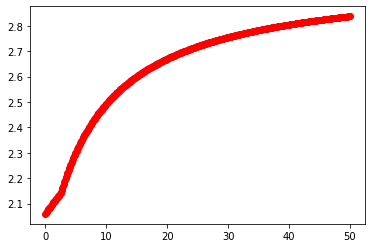

In [51]:
plt.plot(savingsgrid, ev, 'ro')

In [52]:
util_t = util(cons0, choice)

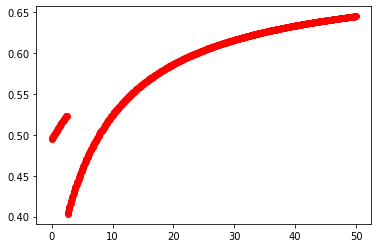

In [53]:
plt.plot(savingsgrid, util_t, 'ro')

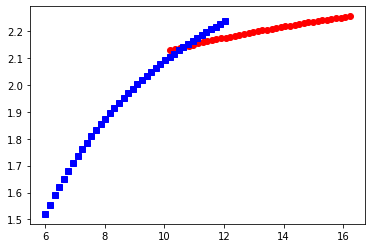

In [62]:
plt.plot(value[40:80, 0, 1, 22], value[40:80, 1, 1, 22], 'ro', value[40:80, 0, 0, 22], value[40:80, 1, 0, 22], 'bs')
# Value functions cross. EGM algorithm is not able to switch from one to the other value function at the crossing point.
# Why?
# Because, mechanically, the M_{t+1} grid we produced at the very beginning retraces the entire surface
# of V_{t+1}, which are not! globally concave. In the non-concave region there are 2 solutions for consumption
# and EGM depicts both. This can be corrected for by removing the unnecesary points as identified by
# the intersection of the choice specific V_t.

In [54]:
value[1:, 1, choice, period] = util(cons0, choice) + df*ev
value[1:, 0, choice, period] = savingsgrid + cons0
value[0, 1, choice, period] = ev[0]

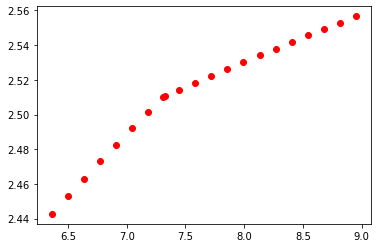

In [55]:
# Points to remove
plt.plot(value[14:35, 0, choice, period], value[14:35, 1, choice, period], 'ro')

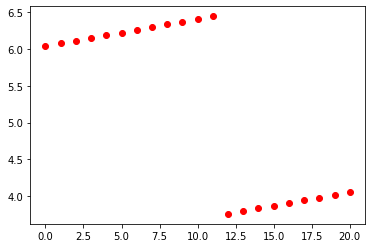

In [63]:
# Points to remove
plt.plot(np.arange(21), cons0[14:35], 'ro')

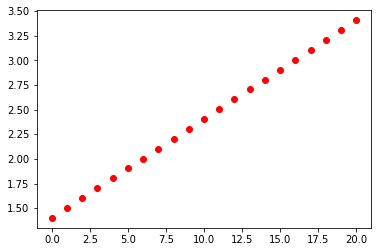

In [57]:
plt.plot(np.arange(21), savingsgrid[14:35], 'ro')

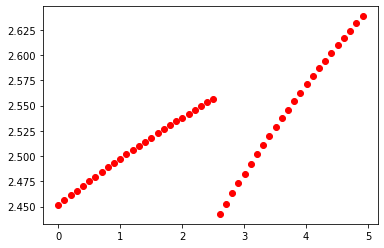

In [58]:
plt.plot(savingsgrid[0:50], value[1:51, 1, choice, period], 'ro')

Solve retiree
=============

Solution of the retirees problem.

Backward induction does not depend on the value function here since because no choice is made. Retirement is an absorbing state.

Questions:

Why does the Gaussian quadrature enter the retirees problem? There is no income involved, quadrature is there to integrate out the shocks/errors in the income process, there are none here??

In [ ]:
# Initialize grids
quadp, quadw = quadrature(expn,0,1)
quadstnorm = scps.norm.ppf(quadp)
savingsgrid = np.linspace(0, mmax, ngridm)

In [ ]:
# Initialize containers

# Container for endogenous gridpoints of (beginning-of-period) assets
# and corresponding consumption
policy = np.full((ngridm + 1, 2, Tbar), np.nan) # dim 0 are x = endog. grid, y are assoc cons values


In [ ]:
# Handling of last period
policy[1:, 0, Tbar-1] = savingsgrid
policy[1:, 1, Tbar-1] = policy[1:, 0, Tbar-1]

In [ ]:
# Ensuring that policy starts with a zero both for x and y for all period
policy[0, :, :] = 0.00

In [ ]:
# Backward induction
choice = 0

for period in reversed(range(Tbar - 1)): # starts at 23, end at zero

    # M_{t+1}
    wk1 = budget(period, savingsgrid, quadstnorm*sigma, choice)

    # Next period consumption based on interpolation and extrapolation
    # given grid points and associated consumption
    cons1 = np.interp(wk1, policy[:, 0, period + 1], policy[:, 1, period+1])
    # extrapolate linearly right of max grid point
    slope = (policy[-2, 1, period + 1] - policy[-1, 1, period + 1])/(policy[-2, 0, period + 1] - policy[-1, 0, period + 1])
    intercept = policy[-1, 1, period + 1] - policy[-1, 0, period + 1]*slope
    cons1[cons1 == np.max(policy[:, 1, period+1])] = intercept + slope*wk1[cons1 == np.max(policy[:, 1, period+1])]
    # Consumption floor
    cons1[cons1 < cfloor] = cfloor

    # Marginal budget
    # Note: Constant for this model formulation
    mwk1 = mbudget()

    # RHS of Euler, integrate out error of y
    rhs = np.dot(quadw.T, np.multiply(mutil(cons1), mwk1))

    ####################
    #Current period vars
    ####################

    # Current period consumption from Euler equation
    cons0 = imutil(df*rhs)

    # Update containers related to consumption
    policy[1:, 0, period] = savingsgrid + cons0 # save x, endog grid M_{t+1}
    policy[1:, 1, period] = cons0 # save y, corresponding consumption


Value function

In [ ]:
# Value function objects
value = np.full((ngridm + 1, 2, Tbar), np.nan) # same dimension meaning as above

In [ ]:
# Handling of last period
value[1:, 0, Tbar - 1] = savingsgrid
value[0, 0, Tbar -1] = 0.00
value[:, 1, Tbar - 1] = 0.00

In [ ]:
for period in reversed(range(Tbar - 1)): # starts at 23, end at zero 

    vfres = np.full(wk1.shape, np.nan)

    if period + 1 == Tbar - 1:
        vfres[:, 1:] = util(wk1[:, 1:], choice)
    else:
        vfres = np.interp(wk1, value[:, 0, period + 1], value[:, 1, period+1])
        slope = (value[-2, 1, period + 1] - value[-1, 1, period + 1])/(value[-2, 0, period + 1] - value[-1, 0, period + 1])
        intercept = value[-1, 1, period + 1] - value[-1, 0, period + 1]*slope
        vfres[vfres == np.max(value[:, 1, period+1])] = intercept + slope*wk1[vfres == np.max(value[:, 1, period+1])]

    # Calculation of EV

    if period + 1 == Tbar - 1:
        ev = np.full(500, -99.00)
        ev[1:] = np.dot(quadw.T, vfres[:, 1:])
    else:
        ev = np.dot(quadw.T, vfres)

    # Calculation of value
    vf_value = util(policy[1:, 1, period], choice) + df*ev

    # Determine value

    value[1:, 0, period] = policy[1:, 0, period]
    value[1:, 1, period] = vf_value
    value[0:(Tbar - period), 1, period] = -99.00